In [1]:
import sys
sys.path.append('../')
from src.d06_reporting.simulation_evaluation import SimulationEvaluation

# Policy: Medium zones with guardrails

To analyze the effectiveness of the tiebreakers, we are going to compare the performance of individual students in the school assignment process for each method to the base scenario where the policy has no equity tiebreaker. For this analysis, we are considering as focal students those individuals who both qualify as African-American, Latinx, or Pacific Islander (AALPI) and are eligible for free or reduced lunch (FRL).

We can tune each of the proposed tiebreakers to an arbitrary point in their respective ROC or Precision and Recall curves. Where we should stand in these curves ultimately depends on the decisions and criteria of the SFUSD.  With this in mind, we are restricting our analysis of tiebreaker performance to the false-positive rate (FPR) of the CTIP1 equity tiebreaker (`ctip1`): 14%. In particular, we are focusing on two alternative tiebreakers: the Naive Classifier at 14% FPR (`naive014`) and a propositional classifier at 14% FPR (`pc3_035`).

The propositional classifier `pc3_035` considers an eligibility criteria of redlined and subsidized housing with an individual block requirement of intersection of FRL and AALPI of more than 40%.

In [2]:
def is_focal(row):
    return int(row['FRL'] & row['AALPI'])

method_name_dict = {'none': 'no ET', 'ctip1': 'CTIP1', 'pc3_030': 'DSSG ET', 'naive016': 'Benchmark'}
se = SimulationEvaluation(method_name_dict=method_name_dict, is_focal=is_focal)
se.set_simulation_config(equity_tiebreaker_list=['none', 'ctip1', 'naive016', 'pc3_030'],
                         num_iterations=20,
                         policy='Medium1',
                         guard_rails=0,
                         utility_model=True)
se.query_rank_df()

In [3]:
se.get_rank_df().groupby('method')['designation'].mean()

method
Benchmark    0.215780
CTIP1        0.218357
DSSG ET      0.215025
no ET        0.216052
Name: designation, dtype: float64

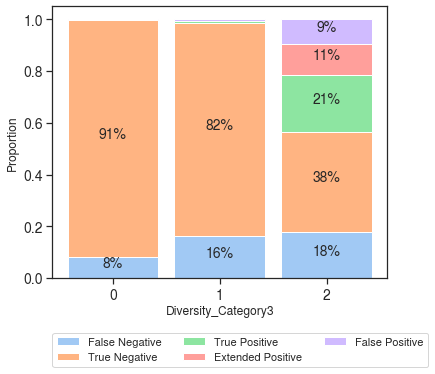

In [4]:
se.rank_results_bar_plot_by_method2(method='ctip1', x_axis='Diversity_Category3', hue='status')

# General distribution of the tiebreaker and focal students

A first step in analyzing the effects of the different equity tiebreakers is to observe the proportion of students that belong to a focal block and the accuracy of the tiebreaker distribution. The latter refers to the distribution of false-negative (FN), true-negative (TN), true-positive (TP), and false-positive (FP).

In [5]:
df = se.get_student_df()
df = df[['FRL', 'AALPI']]
df['Both'] = df['FRL'] & df['AALPI']
df['focal'] = df.apply(lambda row: is_focal(row), axis=1).astype('int64')
df.mean()

FRL      0.415549
AALPI    0.276823
Both     0.216471
focal    0.216471
dtype: float64

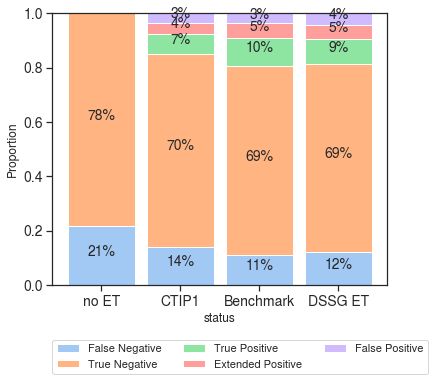

In [6]:
se.rank_results_bar_plot()
# se.rank_results_bar_plot(x_axis="status", hue="method")

In [7]:
df = se.get_rank_df().groupby(['method', 'status'])['rank'].count().unstack('status').fillna(0)
df['FPR'] = df.apply(lambda row: (row['False Positive'] + row['Extended Positive']) / (row['False Positive'] + row['Extended Positive'] + row['True Negative']), axis=1)
df['TPR'] = df.apply(lambda row: (row['True Positive']) / (row['True Positive'] + row['False Negative']), axis=1)
df

status,Extended Positive,False Negative,False Positive,True Negative,True Positive,FPR,TPR
method,,,,,,,
Benchmark,5000.0,10660.0,3520.0,66260.0,10000.0,0.113934,0.484027
CTIP1,3880.0,13560.0,3300.0,67600.0,7100.0,0.096015,0.343659
DSSG ET,4800.0,11700.0,4100.0,65880.0,8960.0,0.119016,0.433688
no ET,0.0,20660.0,0.0,74780.0,0.0,0.000000,0.000000


We can see from the first plot that all three equity tiebreakers target a similar proportion of focal students. From the second plot, we can see that all models have a similar proportion of FPs but the Knapsack Classifier `knapsack014` has a slightly larger number of TPs, followed by the Propositional Classifier `pc2025_040`.

# Quantifing the effects of the tiebreakers

To analyze the actual effects of each tiebreaker, we have generated two results. First, we look at how the average rank for each student changes when there is no equity tiebreaker, the `none` method, to having an equity tiebreaker. To better understand these effects, we divide the analysis by the classification status of each student. That is whether a student is FN, TN, TP, and FP. We then look at the distribution of the average rank for TP students with and without the tiebreaker. The latter is estimated by looking at the average performance of the subset of TP students when there was no equity tiebreaker. The first plot shows a box plot of the distribution of the changes in average rank for students. The second plot shows the average and the 95 confidence interval.

We note that the rank for each student is determined by averaging the ranks over the iterations. Therefore the values aggregated in the following plots underestimate the variance of the outcome ranks of each student.

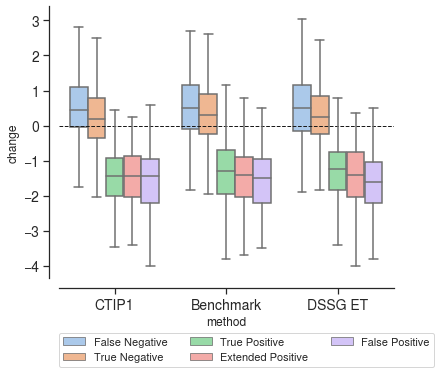

change          
                                 mean       std
method    status                               
Benchmark Extended Positive -1.467200  0.890661
          False Negative     0.535929  0.942849
          False Positive    -1.592898  0.882654
          True Negative      0.336025  0.881076
          True Positive     -1.323600  0.851124
CTIP1     Extended Positive -1.459021  0.845214
          False Negative     0.497788  0.934065
          False Positive    -1.562121  0.867576
          True Negative      0.242648  0.877328
          True Positive     -1.461972  0.801308
DSSG ET   Extended Positive -1.444167  0.921346
          False Negative     0.525812  0.970692
          False Positive    -1.634390  0.904293
          True Negative      0.306269  0.884789
          True Positive     -1.287946  0.841167

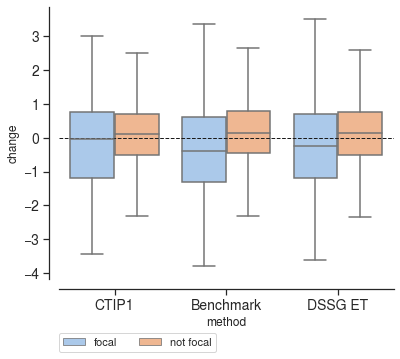

In [8]:
se.plot_improvement_over_none()

It might also be interesting to track the change in average rank of the focal students receiving the equity tiebreaker (TP), without equity tiebreaker, under the method `none` and with the tiebreakers chosen by each methodology. In this case, the first plot shows a box plot of the distribution of ranks under each method. The second plot shows the average performance of students and the 95 confidence interval.

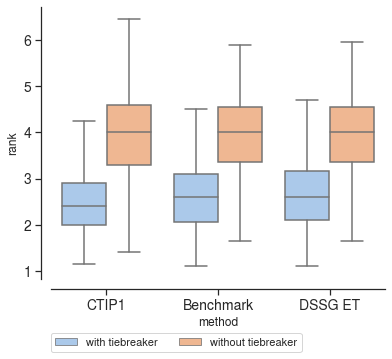

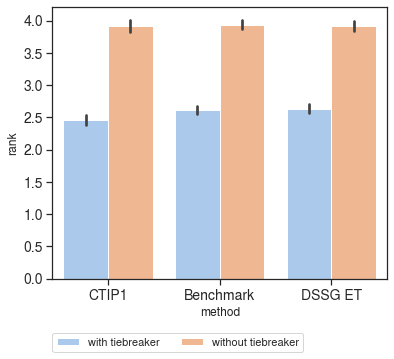

In [9]:
se.plot_improvement_tp()

These plots clearly show that students benefit from receiving the tiebreak. However, this benefit comes at the cost of the students who do not receive the tiebreaker. From the plots of the average change in rank, the size of the effect is similar across methods. One explanation could be that all the students receiving the tiebreaker belong to the same diversity category. Under the current assignment policy, each school has guard rails that restrict the number of seats available for each diversity category. The number of seats available depends on the overall diversity of the zone. This constraint means that students only have to compete against other students in the same diversity category. Since most students who are getting the tiebreaker belong to Diversity Category 2, the most underserved category, the equity tiebreaker prioritizes the TP over the FN. This result does not align with the School District's goal of prioritizing the focal students over the non-focal students.

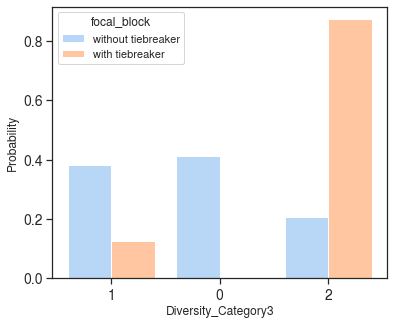

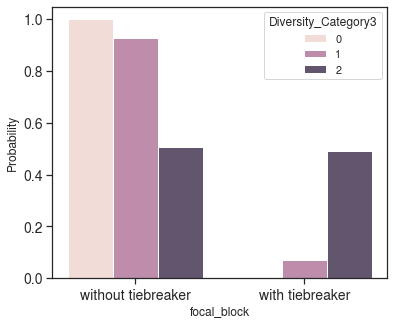

In [10]:
se.rank_results_bar_plot_method(x_axis='Diversity_Category3', hue='focal_block', method='pc3_030')
se.rank_results_bar_plot_method(hue='Diversity_Category3', x_axis='focal_block', method='pc3_030')

For example, if we observe the following plot, showing the average change in students' ranks under the CTIP1 methodology, the most significant improvements that can be associated with the equity tiebreaker are observed for the more privileged diversity category (`Diversity_Category3 == 0`). In other words, when the proportion of focal students within a reserved group is small, the benefit they can extract from the priority of the equity tiebreaker is larger. Although, in this case, we do not have enough observations in the less underserved diversity categories (`Diversity_Category3 in [0, 1]`) to conclude this hypothesis with certainty.

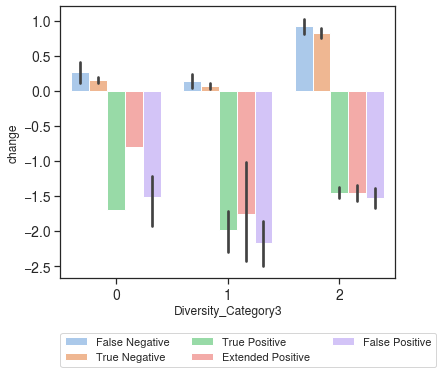

In [11]:
se.plot_improvement_over_none_method(method='ctip1')

These results make us wonder if the FPR of the tiebreaker, or any selection/tunning metric, might affect performance more significantly. This hypothesis is an alternative to the belief that the method we use to select the focal blocks is a defining factor. If we have few FPs, we can expect to observe that most of the benefits from the equity tiebreaker go to the focal students.

Another alternative is reconsidering the definition of focal students to target a smaller fraction of the total population. Since the assignment policy includes guardrails for the different diversity categories, we can expect that under any definition of focal students, one category will concentrate most of them. This correlation between the equity tiebreaker and the diversity categories implies that for the latter to make a significant difference, we need it to target only a small fraction of students. (Rewrite!!)

Finally, we can observe the proportion of students assigned to a school in their top 3 choices. The following plot shows that this proportion does not change significantly in any case, including the case with no equity tiebreaker. One hypothesis is that since focal students generally submit fewer choices, the rank of their options is artificially low. When a student doesn't get assigned one of their choices, the rank of the assignment is the length of their submitted preferences plus 1. In order to overcome this limitation of the analysis, we would be to run these simulations with simulated preferences so that the student choices are similar or equal in length.

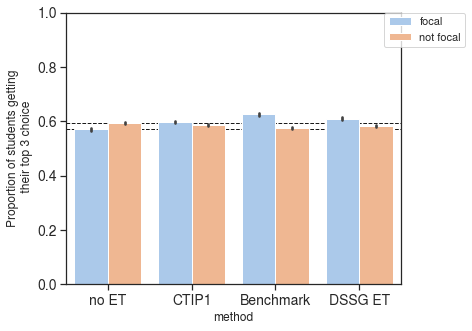

rank          
                         mean       std
method    focal                        
Benchmark focal      0.625460  0.014765
          not focal  0.574659  0.006908
CTIP1     focal      0.596999  0.011485
          not focal  0.584715  0.008182
DSSG ET   focal      0.609535  0.012894
          not focal  0.582669  0.008276
no ET     focal      0.569894  0.011429
          not focal  0.594196  0.007476

In [12]:
se.topkrank()

# Remaining Questions

- Does targeting a smaller fraction of students improve the performance/effects of the equity tiebreaker.

- Thus far, we have not been able to resolve why the tiebreaker has less effect on focal students than on non-focal remains. One hypothesis is that since focal students generally submit fewer choices, the rank of their options is artificially low. When a student doesn't get assigned one of their choices, the rank of the assignment is the length of their submitted preferences plus 1. One way of investigating this hypothesis would be to run these simulations with simulated preferences so that the student choices are similar or equal in length.

- Another question is if the FPR of the tiebreaker, or any selection/tunning metric, affects performance more significantly.


In [13]:
# se.regression_analysis_all()